In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd '/content/drive/MyDrive/Colab Notebooks/Image_Captioning'

/content/drive/MyDrive/Colab Notebooks/Image_Captioning


In [4]:
# numpy_folder = '/numpy/'
# if not os.path.exists(os.path.abspath('.') + numpy_folder):
#   os.makedirs(os.path.abspath('.') + numpy_folder)
# else:
#   print("already exists")

annotation folder 생성, caption dataset 다운, image 폴더 생성, Image dataset 다운

In [5]:
# Download caption annotation files
annotation_folder = '/annotations/'

if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'  
  os.remove(annotation_zip)
else:
  annotation_file = os.path.abspath('.') + '/annotations/captions_train2014.json'
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

JSON 포멧 데이터를 json.load()를 사용하여 Python 객체로 읽어오기

In [6]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

Image Path에 Caption mapping

In [7]:
# key 값이 없을 경우 미리 지정해 놓은 default 값을 반환하는 dictionary
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [8]:
for i in range(0,1):
  print(image_path_to_caption['/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000122857.jpg'])

['<start> A woman walking in front of a shop full of dress beside a moped. <end>', '<start> a person walking in front of a store wit ha scooter <end>', '<start> A woman walking by a store display window at night with  a motor scooter parked in front. <end>', '<start> A person walking down a sidewalk near a moped <end>', '<start> The woman with the motor scooter is looking at dresses. <end>']


Subsampling을 통해 Size 제한중

In [15]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

fail_count = 0
success_count = 0
train_image_paths = []

while success_count < 6000:
  if os.path.exists(image_paths[fail_count + success_count]):
    train_image_paths.append(image_paths[fail_count + success_count])
    success_count += 1
  else:
    fail_count += 1


In [18]:
train_image_paths[0]

'/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000381990.jpg'

In [19]:
train_image_paths[5999]

'/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000062710.jpg'

In [ ]:
ls '/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000311501.jpg'

'/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000311501.jpg'


In [20]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  # image_path_to_caption : caption이 mapping 되어있는 Image path들임
  # 그걸 caption_list로 하겠다.
  caption_list = image_path_to_caption[image_path]
  # train_caption에 caption_list들을 붙여놓기
  train_captions.extend(caption_list)
  # img_name_vector는 subsample로 30000개를 뽑았고,
  # train_img_paths로는 6000개를 쓰니 caption_list만큼 곱해줌.
  # 즉, 하나의 이미지당 캡션이 5개.
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
# print(train_captions[0])
print(img_name_vector[0])
# Image.open(img_name_vector[0])
# ls './train2014/COCO_train2014_0000003672*'

/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000269088.jpg


In [ ]:
ls ./train2014/COCO_train2014_000000269*

^C


Dataset을 적절하게 처리

In [21]:
def load_image(image_path):
  img = tf.io.read_file(image_path) # file 읽고,
  img = tf.io.decode_jpeg(img, channels=3) # image decode하는데 RGB 채널에 맞게 3개,
  img = tf.keras.layers.Resizing(299,299)(img) # 우리 사이즈와 맞게 resizing,
  img = tf.keras.applications.inception_v3.preprocess_input(img) # 이미지 배치를 인코딩하는 Tensor 또는 Numpy 배열을 전처리
  return img, image_path

In [22]:
#InceptionV3 아키텍처를 인스턴스화
#include_top은 맨 마지막 layer에 FC를 추가할 것인지를 물어보는 것.
image_model = tf.keras.applications.InceptionV3(include_top = False,
                                                weights='imagenet')
#image_model을 input으로 한다는 것인가?
new_input = image_model.input
# hidden layer는 image_model
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 5s 0us/step


In [23]:
# img_name_vector를 집합으로 만들고, 정렬
# 원래 set은 순서가 없음.
encode_train = sorted(set(img_name_vector))

#encode_train dataset을 여러 tesnor로 짜르기
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#
image_dataset = image_dataset.map(load_image,
                                  num_parallel_calls = tf.data.AUTOTUNE).batch(16)

In [ ]:
print(encode_train[0])

/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000000049.jpg


In [ ]:
# pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24590 sha256=3071a1a2bce1193b8103d4a170d86b87dc792b74d18254c74d27da02d26fe650
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built parse


In [ ]:
# from parse import *
# # type(path)
# for img, path in image_dataset:
#   result = parse('/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/{}',"path")

KeyboardInterrupt: ignored

In [ ]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                        (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
# 예외 갯수가 무려 375개?
# print(count)

batch_features

In [ ]:
#train_caption : image_path + 캡션 리스트들이 들어있음
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# 다른 문자열들을 전처리해주는 과정
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")
  
max_length = 50

vocabulary_size = 5000

# 모델에 데이터를 넣기 위한 전처리 하는 과정
tokenizer = tf.keras.layers.TextVectorization(max_tokens = vocabulary_size,
                                             standardize = standardize,
                                             output_sequence_length = max_length)
#caption_dataset에 적용 (vocabulary를 만들다.)
tokenizer.adapt(caption_dataset)

In [ ]:
#tokenizer vector 만들기
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# count = 0 
# for i in caption_dataset:
#   if count == 5:
#     break
#   print(i)
#   count+=1

tf.Tensor(b'<start> A large teddy bear laying on a pillow with a blanket over it. <end>', shape=(), dtype=string)
tf.Tensor(b'<start> A teddy bear resting his head on a pillow in a bed. <end>', shape=(), dtype=string)
tf.Tensor(b'<start> Teddy bear laying on a bed covered by a sheet. <end>', shape=(), dtype=string)
tf.Tensor(b'<start> a teddy bear in a bed under the covers with his head lying on a pillow <end>', shape=(), dtype=string)
tf.Tensor(b'<start> a teddy bead laying on the bed and partially under a blanket <end>', shape=(), dtype=string)


In [ ]:
# 마치 Word Embedding처럼 각 data value들이 index로 표현될 수 있도록 도와주는 함수
word_to_index = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary = tokenizer.get_vocabulary())
# 그것의 반대
index_to_word = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=tokenizer.get_vocabulary(),
                                             invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
# image에다가 img_name_vector와 cap_vector를 튜플의 형태 추가
for img,cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

#img_to_cap_vector의 키만 뽑아내고
img_keys = list(img_to_cap_vector.keys())
# 키를 셔플
random.shuffle(img_keys)

#train, test 데이터 나누고,
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# train 데이터 세팅
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  #len(img_to_cap_vector[imgt])이면, imgt
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])
# validation 데이터 세팅
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
print(img_to_cap_vector['/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000488135.jpg'])

[]


In [ ]:
# 7500개 5개씩 곱했는데 3개는 어디서 나온건지 ... 
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24014, 24014, 6002, 6002)

training을 어떻게 할지 파라미터들 지정중

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [ ]:
#utf-8로 decode하고 .npy 파일 불러오기
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8') + '.npy')
  return img_tensor, cap

In [ ]:
#여러 tensor로 짜르고,
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
count = 0
for i in dataset:
  if count == 4:
    break
  print(i)
  count+=1
#dataset을 item1,item2에 맞게 map function 수행
#tf.numpy_function은 numpy 배열을 출력으로 리턴
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int64]),
    num_parallel_calls = tf.data.AUTOTUNE)
#dataset을 설정한 값만큼 shuffle 및 batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#data를 prefetch(미리 가져옴)
dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)


(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000175805.jpg'>, <tf.Tensor: shape=(50,), dtype=int64, numpy=
array([   3,    2,  221,  263, 2506,   10,    2,  221,   98,  100,  230,
        191,    5,    2,  101,    4,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/Image_Captioning/train2014/COCO_train2014_000000175805.jpg'>, <tf.Tensor: shape=(50,), dtype=int64, numpy=
array([   3,   15,  221,  343, 1532,    5,    2,  101,    9,   22, 1799,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 

In [ ]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

# 어텐션
이전 값들을 모두 활용해서 layer를 만들어보자.

# 바나다우 어텐션

In [ ]:
# 바다나우 어텐션
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1) 
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + 
                                          self.W2(hidden_with_time_axis)))
      
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
# 입력으로 받은 이미지를 더 작은 이미지로 인코딩
# 원본 이미지의 유용한 정보를 요약하는 과정
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

#  class CNN_Encoder(tf.keras.Model):
#     # Since you have already extracted the features and dumped it
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self, embedding_dim):
#         super(CNN_Encoder, self).__init__()
#         # shape after fc == (batch_size, 64, embedding_dim)
#         self.fc = tf.keras.layers.Dense(embedding_dim)

#     def call(self, x):
#         x = self.fc(x)
#         x = tf.nn.relu(x)
#         return x
   

In [ ]:
# 인코딩된 이미지를 보고 이미지의 설명 문장을 생성
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #GRU 사용
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    # Dense Layer란?
    # 추출된 정보들을 하나의 레이어로 모으고, 우리가 원하는 차원으로 축소시켜서 표현하기 위한 레이어
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    output, state = self.gru(x)

    x = self.fc1(output)
    
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
# optimizer를 adam으로 쓸꺼고,
optimizer = tf.keras.optimizers.Adam()
# label(실제값인듯?)과 prediction 사이의 crossentropty loss를 구하려고함.
# cross-entropy loss : 정답 클래스에 해당하는 스코어에 대해서만 로그합을 구하여 최종 Loss를 구함.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# checkpoint 설정
checkpoint_path = "./checkpoint/train"
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  # print(ckpt_manager.latest_checkpoint)
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
print(start_epoch)

0


In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size = target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss/ int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9855


KeyboardInterrupt: ignored

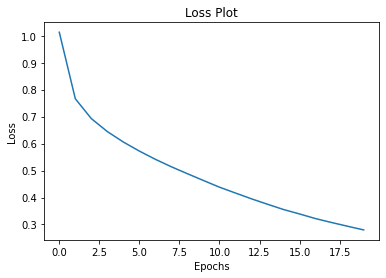

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    #0으로 채워진 array 생성
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)


In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

tf.Tensor(
[[[ 0.22233498  0.08900166 -0.14629233]
  [ 0.23110795  0.08047032 -0.14564168]
  [ 0.23486292  0.08017659 -0.13465637]
  ...
  [ 0.23724389  0.2931013   0.5461881 ]
  [-0.03544372 -0.04830307  0.03253376]
  [-0.76776475 -0.7992188  -0.6966386 ]]

 [[ 0.20840001  0.07000518 -0.14791548]
  [ 0.2588055   0.10256875 -0.10528398]
  [ 0.22973645  0.07287371 -0.13435298]
  ...
  [ 0.07151937  0.13835156  0.38328207]
  [-0.14185262 -0.16920853 -0.05056596]
  [-0.79164314 -0.8543191  -0.77077657]]

 [[ 0.06250238 -0.09075111 -0.3091663 ]
  [ 0.23536026  0.07966471 -0.13793635]
  [ 0.10179627 -0.05389923 -0.27150035]
  ...
  [-0.01999879  0.04027677  0.26285923]
  [-0.39060235 -0.42375624 -0.31264263]
  [-0.79641026 -0.8325987  -0.8767282 ]]

 ...

 [[-0.4331233  -0.45208085 -0.28269172]
  [-0.28474474 -0.20776796 -0.13610995]
  [-0.39313567 -0.28197408 -0.20446914]
  ...
  [-0.13222772 -0.08153057  0.08558345]
  [-0.09569031 -0.03328067  0.18894923]
  [-0.09356517  0.03876936  0.307

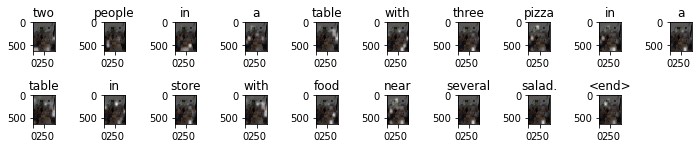

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

annotations/  checkpoint/  Image_Captioning.ipynb  윤혁식.jpeg  train2014/


tf.Tensor(
[[[ 0.04272234  0.11331058  0.2466439 ]
  [ 0.0602138   0.13080204  0.26413536]
  [ 0.06884384  0.13943207  0.2727654 ]
  ...
  [ 0.11661088  0.21072853  0.3362187 ]
  [ 0.11359286  0.2077105   0.3332007 ]
  [ 0.1211524   0.21527004  0.34076023]]

 [[ 0.01017773  0.08076596  0.21409929]
  [ 0.01026952  0.08085775  0.21419108]
  [ 0.01889956  0.08948779  0.22282112]
  ...
  [ 0.07538855  0.16950619  0.29499638]
  [ 0.08208978  0.17620742  0.3016976 ]
  [ 0.09275246  0.1868701   0.3123603 ]]

 [[ 0.03025758  0.10084593  0.23417926]
  [ 0.01207948  0.08266771  0.21600103]
  [ 0.01802087  0.0886091   0.22194242]
  ...
  [ 0.07043087  0.16454852  0.2900387 ]
  [ 0.07482994  0.16894758  0.29443777]
  [ 0.08337712  0.17749476  0.30298495]]

 ...

 [[ 0.18074429  0.06309724 -0.16435385]
  [ 0.13066387  0.01301682 -0.21443427]
  [ 0.12335515  0.0057081  -0.22174287]
  ...
  [ 0.24598193  0.11233366 -0.07966566]
  [ 0.27090836  0.13726008 -0.05473924]
  [ 0.28500116  0.15135288 -0.040

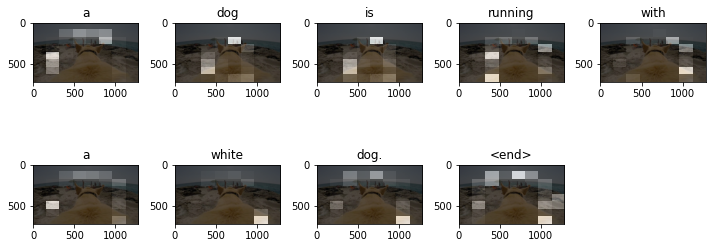

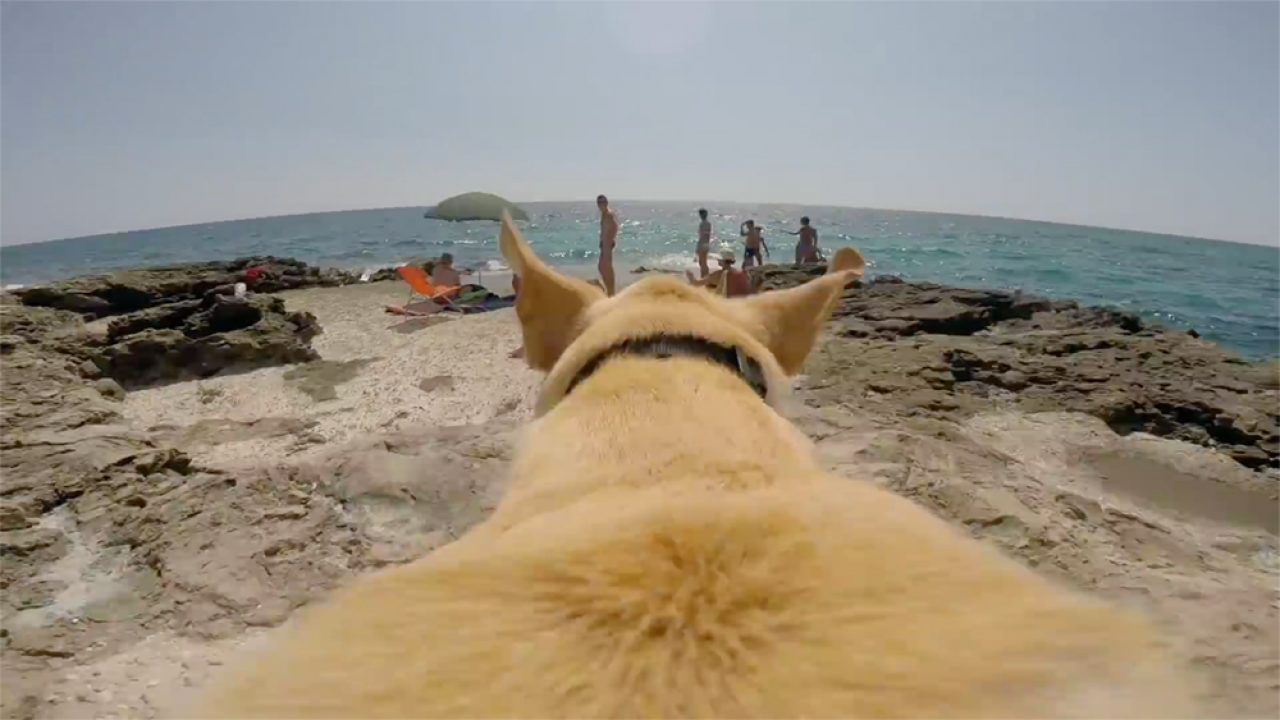

In [ ]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

image_path = './dogs2.jpeg'
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
Image.open(image_path)

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Image_Captioning'

In [ ]:
print(ckpt_manager.checkpoints)

['./checkpoint/train/ckpt-1', './checkpoint/train/ckpt-2', './checkpoint/train/ckpt-3', './checkpoint/train/ckpt-4']


In [ ]:
ls ./checkpoint/train

checkpoint                  ckpt-3.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-3.index
ckpt-1.index                ckpt-4.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-4.index
ckpt-2.index


In [ ]:
latest_ckpt = tf.train.latest_checkpoint(checkpoint_path)

In [ ]:
reader = tf.train.load_checkpoint(checkpoint_path)
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'decoder/attention/V/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W2/bias/.ATTRIBUTES/VARIABLE_VALU

In [ ]:
model = create_model()
model.load_weight(checkpoint_path)

'./checkpoint/train/ckpt-4'

In [ ]:
# checkpoint를 로드하여 결과 확인? 어떻게 하지